In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
base_dir = root_dir + 'fastai-v3/'

In [14]:
root_dir = '/Users/dbiagini/dev/nn-serology/'  
!curl -s https://course.fast.ai/setup/colab | bash

mkdir: /root/.torch/models: Read-only file system
mkdir: /root/.fastai/data: Read-only file system
ln: /content: Read-only file system
ln: /content: Read-only file system
Updating fastai...
Done.


In [15]:
import pandas as pd
import numpy as np
from fastai import *
from fastai.tabular import *

In [16]:
# multi-purpose function to parse each type of file
def _parse(tng_file, tst_file, val_file):
    tng_dict = {}
    tst_dict = {}
    val_dict = {}
    AA_dict = {}

    # loop through each line of the training file
    for each in tng_file:
        #values = []
        AAs = []
        trick = {}
        # will only be executed once, to create a list of the polymorphic amino acids
        if each.find("No. of output") != -1:
            each = next(tng_file)
            AA = each.strip("# ")
            AA_list = AA.split()
            continue
        # main purpose, identifying the hashtags at the beginning of the significant lines
        if each.find("#") != -1:
            # gathering information on a specific allele
            if (each.find("# input") == -1) & (each.find("# output") == -1):
                temp = each.strip("# ")
                allele = temp.rstrip()
                continue
            # looking for the binary values corresponding to the amino acid polymorphisms
            elif each.find("# input") != -1:
                line = next(tng_file)
                # generating a list of the binary values
                bin_val = line.split()
                bin_val = list(map(int, bin_val))
                # the values for the specific amino acid are zipped into a dictionary with the polymorphic AAs as the keys
                ##AA_dict = dict(zip(AA_list, bin_val))
                ##values.append(AA_dict)
                line = next(tng_file)
                out_lines_idx = line
                specificities_n = out_lines_idx.strip("# output")
                specificities_f = specificities_n.rstrip()
                specificities = specificities_f.split()
                line = next(tng_file)
                out_vals = line.strip(' ').split()
                out_vals = list(map(float,out_vals))
                out_dict = dict(zip(specificities, out_vals))
                for spec in list(out_dict):
                  if out_dict[spec] == 0.00:
                    del(out_dict[spec])
                serology = list(out_dict)
                serology = list(map(str,serology))
                for val in range(len(serology)):
                  serology[val] += 'a'
                #values.append(out_dict)
                spacer = ';'
                serology = spacer.join(serology)
                AAs = ['allele'] + AA_list
                values = [allele] + bin_val
                trick = dict(zip(AAs, values))
                trick['serology'] = serology
                
                tng_dict[allele] = trick

    # basically the same, but to parse the testing file
    for each in tst_file:
        #values = []
        AAs = []
        trick = {}
        if each.find("#") != -1:
            if (each.find("# input") == -1) & (each.find("# output") == -1):
                temp = each.strip("# testing ")
                allele = temp.rstrip()
                continue
            elif each.find("# input") != -1:
                line = next(tst_file)
                bin_val = line.split()
                bin_val = list(map(int,bin_val))
                #AA_dict = dict(zip(AA_list, bin_val))
                #values.append(AA_dict)
                '''
                line = next(tst_file)
                out_lines_idx = line
                specificities_n = out_lines_idx.strip("# output")
                specificities_f = specificities_n.rstrip()
                specificities = specificities_f.split()
                line = next(tst_file)
                out_vals = line.split()
                out_vals = list(map(float,out_vals))
                out_dict = dict(zip(specificities, out_vals))
                for spec in list(out_dict):
                  if out_dict[spec] == 0.00:
                    del(out_dict[spec])
                serology = list(out_dict)
                serology = list(map(str,serology))
                for val in range(len(serology)):
                  serology[val] += 'a'
                #values.append(out_dict)
                '''
                AAs = ['allele'] + AA_list + ['serology']
                values = [allele] + bin_val
                trick = dict(zip(AAs, values))
                trick['serology'] = None
                tst_dict[allele] = trick

     # final loop to parse the validation file       
    for each in val_file:
        #values = []
        AAs = []
        trick = {}
        if each.find("#") != -1:
            if (each.find("# input") == -1) & (each.find("# output") == -1):
                temp = each.strip("# ")
                allele = temp.rstrip()
                continue
            elif each.find("# input") != -1:
                line = next(val_file)
                bin_val = line.split()
                bin_val = list(map(int,bin_val))
                #AA_dict = dict(zip(AA_list, bin_val))
                #values.append(AA_dict)
                line = next(val_file)
                out_lines_idx = line
                specificities_n = out_lines_idx.strip("# output")
                specificities_f = specificities_n.rstrip()
                specificities = specificities_f.split()
                line = next(val_file)
                out_vals = line.strip(' ').split()
                out_vals = list(map(float,out_vals))
                out_dict = dict(zip(specificities, out_vals))
                for spec in list(out_dict):
                  if out_dict[spec] == 0.00:
                    del(out_dict[spec])
                serology = list(out_dict)
                serology = list(map(str,serology))
                for val in range(len(serology)):
                  serology[val] += 'a'
                #values.append(out_dict)
                spacer = ';'
                serology = spacer.join(serology)
                AAs = ['allele'] + AA_list
                values = [allele] + bin_val
                trick = dict(zip(AAs, values))
                trick['serology'] = serology

                val_dict[allele] = trick
    return(tng_dict, tst_dict, val_dict)

def _file_handler():
    # opening files to send to the parser
    # there is almost definitely a much simpler way to code this

    loci = ["A", "B", "C", "DPB1", "DQB1", "DRB1"]
    output_list = []
    
    for each in loci:
        training_file = open(root_dir + each + ".tng.pat", 'r')
        testing_file = open(root_dir + each + ".tst.pat", 'r')
        validation_file = open(root_dir + each + ".val.pat", 'r')
        tng_dict, tst_dict, val_dict = _parse(training_file, testing_file, validation_file)
        output_list.append(tng_dict)
        output_list.append(tst_dict)
        output_list.append(val_dict)
        training_file.close()
        testing_file.close()
        validation_file.close()

    A = output_list[0:3]
    B = output_list[3:6]
    C = output_list[6:9]
    DPB1 = output_list[9:12]
    DQB1 = output_list[12:15]
    DRB1 = output_list[15:18]

    return(A, B, C, DPB1, DQB1, DRB1)



In [17]:

A, B, C, DPB1, DQB1, DRB1 = _file_handler()

A_tng = A[0]
A_tst = A[1]
A_val = A[2]
tng_alleles = []
tst_alleles = []
val_alleles = []
tng_AAs = []
tst_AAs = []
val_AAs = []
AAs = []
specificities = []

for key in A_tng.keys():
  tng_alleles.append(key)
  tng_AAs.append(A_tng[key])
  for each_dict in tng_AAs:
    for each in each_dict:
      if each_dict[each] == 0:
        each_dict[each] = False
      elif each_dict[each] == 1:
        each_dict[each] = True

for tst_key in A_tst.keys():
  tst_alleles.append(tst_key)
  tst_AAs.append(A_tst[tst_key])
  for each_dict in tst_AAs:
    for each in each_dict:
      if each_dict[each] == 0:
        each_dict[each] = False
      elif each_dict[each] == 1:
        each_dict[each] = True

for val_key in A_val.keys():
  val_alleles.append(val_key)
  val_AAs.append(A_val[val_key])
  for each_dict in val_AAs:
    for each in each_dict:
      if each_dict[each] == 0:
        each_dict[each] = False
      elif each_dict[each] == 1:
        each_dict[each] = True

for each in tng_AAs[0].keys():
  if (each != 'serology') & (each != 'allele'):
    AAs.append(each)


tng_df = pd.DataFrame(data = tng_AAs)
val_df = pd.DataFrame(data = val_AAs)
df = tng_df.append(val_df)
tng_idx = len(tng_df)
val_idx = len(val_df)
tst_df = pd.DataFrame(data = tst_AAs)

dep_var = 'serology'
cat_names = ['allele'] + AAs
procs = [FillMissing, Categorify]


In [30]:
cat_names = AAs
test = TabularList.from_df(tst_df, path=Path(''), cat_names=cat_names, cont_names=None)
data = (TabularList.from_df(df=df, path=Path(''), procs=procs, cat_names=cat_names, cont_names=None)
                            .split_by_idx(list(range(tng_idx,tng_idx+val_idx)))
                            .label_from_df(cols=dep_var, label_delim=';')
                            .add_test(test)
                            .databunch(bs=37, num_workers=0))
                          

In [31]:
data.show_batch(rows = 37)

A1,G1,F9,S9,T9,Y9,M12,V12,R17,S17,S31,T31,Q35,R35,Q43,R43,K44,R44,E56,G56,R56,E62,G62,L62,Q62,R62,E63,N63,Q63,G65,R65,K66,N66,M67,V67,H70,Q70,I73,T73,D74,H74,N74,A76,E76,V76,D77,N77,S77,G79,R79,I80,T80,A81,L81,L82,R82,G83,R83,A90,D90,I95,L95,V95,I97,M97,R97,C99,F99,Y99,D102,H102,P105,S105,G107,W107,F109,L109,E114,H114,Q114,R114,D116,H116,N116,Y116,K127,N127,I142,T142,K144,Q144,H145,R145,A149,T149,A150,V150,H151,R151,A152,E152,R152,V152,W152,L156,Q156,R156,W156,A158,V158,D161,E161,E163,R163,T163,D166,E166,G167,W167,H171,Y171,target
False,True,False,False,False,True,False,True,True,False,False,True,False,True,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,True,True,False,False,True,True,False,False,False,False,True,False,False,True,True,False,True,False,True,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,False,False,False,False,False,True,True,False,False,True,False,True,False,False,True,False,True,False,True,43a
False,True,True,False,False,False,False,True,True,False,False,True,False,True,True,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,True,True,False,False,True,True,False,False,False,True,False,False,False,True,True,False,True,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,False,True,1a
False,True,False,True,False,False,False,True,True,False,False,True,False,True,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False,True,True,False,False,False,True,False,False,True,False,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,True,False,False,True,True,False,True,False,False,True,False,False,False,False,False,True,True,False,True,False,True,False,False,True,True,False,True,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,False,False,True,24a;9a
False,True,True,False,False,False,False,True,True,False,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,True,False,False,True,True,False,False,True,False,True,False,False,False,True,True,False,False,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False,True,False,True,True,False,False,True,False,False,False,False,False,True,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,True,False,True,False,True,2a
False,True,False,False,False,True,False,True,True,False,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,True,False,False,True,True,False,False,True,False,True,False,False,False,True,True,False,False,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False,True,False,True,True,False,False,True,False,False,False,False,False,True,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,True,False,True,False,True,2a
False,True,False,False,False,True,False,True,True,False,Fa

In [138]:
acc_02 = partial(accuracy_thresh, thresh=0.55)
f_score = partial(fbeta, thresh=0.55)

learn = tabular_learner(data, layers=[30], loss_func=MSELossFlat(), metrics=[acc_02,f_score])
print(data.classes)

['10a', '11a', '1a', '23a', '24a', '25a', '26a', '28a', '29a', '2a', '30a', '31a', '32a', '33a', '34a', '36a', '3a', '43a', '66a', '68a', '69a', '74a', '80a', '9a']


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 3.02E-02


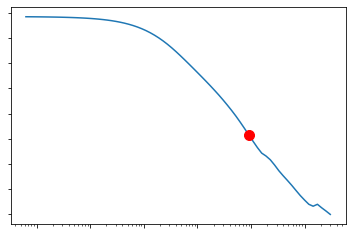

In [139]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [140]:
learn.fit(100, lr=1.74e-2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.099250,0.061628,0.945565,0.000000,00:00
1,0.125153,0.056264,0.945565,0.000000,00:00
2,0.111589,0.051032,0.945565,0.000000,00:00
3,0.099202,0.047371,0.925403,0.118280,00:00
4,0.088306,0.046014,0.920027,0.118280,00:00
5,0.080062,0.045810,0.930780,0.425627,00:00
6,0.073303,0.045277,0.920027,0.369048,00:00
7,0.068041,0.044085,0.917339,0.334590,00:00
8,0.063830,0.042771,0.912634,0.297829,00:00
9,0.060372,0.041833,0.921371,0.263825,00:00


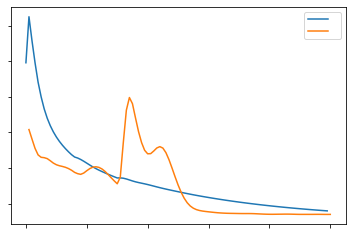

In [141]:
learn.model
learn.recorder.plot_losses()

In [142]:
learn.show_results(rows=100)
interp = ClassificationInterpretation.from_learner(learn)

A1,G1,F9,S9,T9,Y9,M12,V12,R17,S17,S31,T31,Q35,R35,Q43,R43,K44,R44,E56,G56,R56,E62,G62,L62,Q62,R62,E63,N63,Q63,G65,R65,K66,N66,M67,V67,H70,Q70,I73,T73,D74,H74,N74,A76,E76,V76,D77,N77,S77,G79,R79,I80,T80,A81,L81,L82,R82,G83,R83,A90,D90,I95,L95,V95,I97,M97,R97,C99,F99,Y99,D102,H102,P105,S105,G107,W107,F109,L109,E114,H114,Q114,R114,D116,H116,N116,Y116,K127,N127,I142,T142,K144,Q144,H145,R145,A149,T149,A150,V150,H151,R151,A152,E152,R152,V152,W152,L156,Q156,R156,W156,A158,V158,D161,E161,E163,R163,T163,D166,E166,G167,W167,H171,Y171,target,prediction
False,True,True,False,False,False,False,True,True,False,False,True,False,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,True,False,True,True,False,False,True,True,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False,True,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,True,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,False,True,1a,1a
False,True,True,False,False,False,False,True,True,False,False,True,False,True,True,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,True,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,True,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,True,1a,1a
False,True,True,False,False,False,False,True,True,False,False,True,False,True,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,True,False,False,True,True,False,False,True,False,True,False,False,False,True,True,False,False,True,False,False,True,False,True,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True,True,False,False,True,False,True,True,False,False,True,False,False,False,False,False,True,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,True,2a,2a
False,True,False,False,False,True,False,True,True,False,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,True,False,False,True,False,True,False,False,False,True,True,False,False,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False,True,False,True,True,False,False,True,False,False,False,False,False,True,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,True,False,True,False,True,2a,2a
False,True,True,False,False,False,False,True,True,False,False,True,False,True,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,True,False,False,True,True,False,False,True,False,True,False,False,False,True,True,False,False,True,False,False,True,False,True,False,True,True,False,True,False,False,False,True,False,False,True,False,False,True,True,False,False,True,False,True,True,False,False,True,False,False,False,False,False,True,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,True,2a,2a
False,True,True,False,False,False,Fa

In [144]:
test_id = list(tst_df['allele'])
for j in range(0,len(test_id)):
  test_id[j] = 'A*' + test_id[j] 

classes = data.classes
predictions = []

for i in range(0,1692):
  category = str(learn.predict(tst_df.iloc[i], thresh=0.40)[0])
  sero = category.strip('MultiCategory ')
  sero = sero.replace(';',' ')
  predictions.append(sero.split())

# below code involved help from some website using fast.ai to demonstrate kaggle solutions
output_preds = pd.DataFrame({'allele': test_id, 'serology': predictions})
output_preds.to_csv(root_dir + 'predictions.csv', index=False)